# Task 1: Acquire, pre-process and analyze the data
## Acquiring both datasets:
Dataset 1: [Search Trends](https://github.com/google-research/open-covid-19-data/blob/master/data/exports/search_trends_symptoms_dataset/README.mdhttps://)

Dataset 2: [COVID hospitalization cases](https://github.com/google-research/open-covid-19-data)

In [1]:
# Imports

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# the week of 08/24/2020 for the data collection
# Load into pandas dataframes
st_df = pd.read_csv('2020_US_weekly_symptoms_dataset.csv', low_memory=False)
hp_df = pd.read_csv('aggregated_cc_by.csv', low_memory=False)

## Preprocess the datasets

## Target Weeks range: 2020-03-09 to 2020-09-21


In [3]:
# Search trends dataset Part I

#TODO: Preprocessing, remove all symptoms that have all zero entries (clean COLUMN)
st_df = st_df.dropna(how='all', axis=1)

#Remove all rows not in the date of the week chosen (clean ROW)
st_df = st_df[st_df['date'] >= '2020-03-04']

nameList = list(st_df['sub_region_1']) #extract the region names from st_df database
nameList = list(dict.fromkeys(nameList))  #remove duplicates

In [4]:
# Hospitalization dataset Part I

#TODO: Preprocessing

#keep the hospitalization features and delete the rest  (clean COLUMN)
hp_df = hp_df[['open_covid_region_code','region_name','date', 'hospitalized_new']]

#select the regions that match the Search trends dataset (clean ROW)
hp_df= hp_df[hp_df.region_name.isin(nameList)]

#select the regions that have the valid date range (clean ROW)
hp_df = hp_df[(hp_df['date'] >= '2020-03-09') & (hp_df['date'] <= '2020-09-27')]

hp_df.reset_index(inplace = True) 
# print(hp_df.to_string())

In [5]:
# Hospitalization dataset Part II
# Here we want to group dates in the same week together as one date (the weekdate)
hp_df1 = hp_df
weekdate = '2020-03-09'

#This loop will update all the dates row by row
for i, n in hp_df1.iterrows():
    if (i%7 == 0):
        weekdate = n['date']  #first date of the week
    else:
        hp_df1.at[i,'date'] = weekdate

In [6]:
#sum up the hospitalized_vew for weekly
# we are only using this hp_df2 to rid regions that have insignificant hospitalized data, such as 0 for total hospitalization
def cleanRegions(df):
    hp_df2 = df
    f = dict.fromkeys(hp_df2.columns.difference(['region_name']), 'first')
    f['hospitalized_new'] = sum
    hp_df2 = hp_df2.groupby('region_name', as_index=False).agg(f)
    hp_df2 = hp_df2[hp_df2.hospitalized_new != 0]
    print(hp_df2.to_string())
    tmplist = list(hp_df2['region_name']) 
    tmplist = list(dict.fromkeys(tmplist))  
    return(tmplist)

#this nameList will be a new regions list that removes region with total of 0 hospitalization value for all its dates
nameList2 = cleanRegions(hp_df1)

#filter hp_df1 based on the nameList2 (clean ROW)
hp_df2= hp_df1[hp_df1.region_name.isin(nameList2)]

      region_name        date  hospitalized_new  index open_covid_region_code
3          Hawaii  2020-03-09             802.0  87097                  US-HI
4           Idaho  2020-03-09            1811.0  86678                  US-ID
5           Maine  2020-03-09             445.0  84953                  US-ME
6         Montana  2020-03-09             687.0  83701                  US-MT
7        Nebraska  2020-03-09            2279.0  83071                  US-NE
8   New Hampshire  2020-03-09             736.0  82860                  US-NH
9      New Mexico  2020-03-09            3435.0  82413                  US-NM
10   North Dakota  2020-03-09             815.0  83280                  US-ND
11   Rhode Island  2020-03-09            2725.0  80738                  US-RI
12   South Dakota  2020-03-09            1473.0  80311                  US-SD
15        Wyoming  2020-03-09             262.0  78166                  US-WY


In [7]:
# Hospitalization dataset Part III

# merge 7 week rows into 1 and sum up the hospitalized_new data
hp_df3 = hp_df2.groupby(['region_name','date'])['hospitalized_new'].apply(sum).reset_index()

In [8]:
# Search trends dataset Part II

# Drop unnecessary columns (open_covid region_code, country_region_code, country_region) (clean COLUMN)
st_df1 = st_df.drop(st_df.columns[[0, 1, 2]], axis=1)

# Filter st_df based on nameList2 (clean ROW)
st_df1= st_df1[st_df.sub_region_1.isin(nameList2)]
# print(st_df1)
# print(st_df1.shape)

#Filter columns so that every column have at least sp_num% of non-zero entries  (clean COLUMN)
sp_num = 0.24  #optimized ratio without tremendous loss of dataset
st_df2 = st_df1.dropna(thresh=sp_num*len(st_df), axis=1)
# print("after........." )
# print(st_df2)
# print(st_df2.shape)

## Merging the datasets 

In [9]:
hpData = hp_df3["hospitalized_new"]
hpData = pd.Series(hpData)

st_df2['hospitalized_new'] = hpData.values # Merging the data_set
print(st_df2)

     sub_region_1 sub_region_1_code        date  symptom:Adrenal crisis  \
123        Hawaii             US-HI  2020-03-09                     NaN   
124        Hawaii             US-HI  2020-03-16                     NaN   
125        Hawaii             US-HI  2020-03-23                     NaN   
126        Hawaii             US-HI  2020-03-30                     NaN   
127        Hawaii             US-HI  2020-04-06                     NaN   
128        Hawaii             US-HI  2020-04-13                     NaN   
129        Hawaii             US-HI  2020-04-20                     NaN   
130        Hawaii             US-HI  2020-04-27                     NaN   
131        Hawaii             US-HI  2020-05-04                     NaN   
132        Hawaii             US-HI  2020-05-11                     NaN   
133        Hawaii             US-HI  2020-05-18                     NaN   
134        Hawaii             US-HI  2020-05-25                     NaN   
135        Hawaii        

In [10]:
# Convert merged dataset into a numpy array
myarray = pd.DataFrame(st_df2).to_numpy()

# Task 2: Visualize and Cluster the Data

## Visualizing the evolution of the search frequency of popular symptoms

In [11]:
# Imports
import matplotlib.pyplot as plt

In [12]:
# Replace NaN values by 0s
myarray[pd.isnull(myarray)] = 0

In [13]:
regions = myarray[:,0]
time = myarray[:,2]
features = myarray[:,3:-1].astype(float)
label = myarray[:,-1].astype(int)

nData, nFeat = features.shape

In [14]:
# Get list of symptom names
nameSymptoms = np.array([])
for name in st_df2.columns.values[3:-1]:
    nameSymptoms = np.append(nameSymptoms, name.lstrip('symptom:'))

# print(nameSymptoms)

In [15]:
# Find the most popular searches (rank by # of instances)
mostPop = 5

arrInst = np.count_nonzero(features, axis=0)
# Get indices of most popular searches
topSearchInd = np.sort(np.argpartition(arrInst, -mostPop)[-mostPop:])
# print(topSearchInd)

In [16]:
# Get list of symptom names of most popular searches
namePopSymptoms = nameSymptoms[topSearchInd]
# print(namePopSymptoms)

# Get array of features of only the most popular searches
popFeatures = features[:,topSearchInd]
# print(popFeatures.shape)

In [17]:
# Reshape search data 2D array into 3D [region, time, feature]

uniqueRegions, ctRegions = np.unique(regions, return_counts=True)
# print(dict(zip(uniqueRegions, ctRegions)))

uniqueTime, ctTime = np.unique(time, return_counts=True)
# print(dict(zip(uniqueTime, ctTime)))

nRegions = ctTime[0]
nTime = ctRegions[0]

sdArr = popFeatures.reshape(-1, nTime, mostPop)
# print(sdArr.shape)
# print(sdArr[0,:,2])

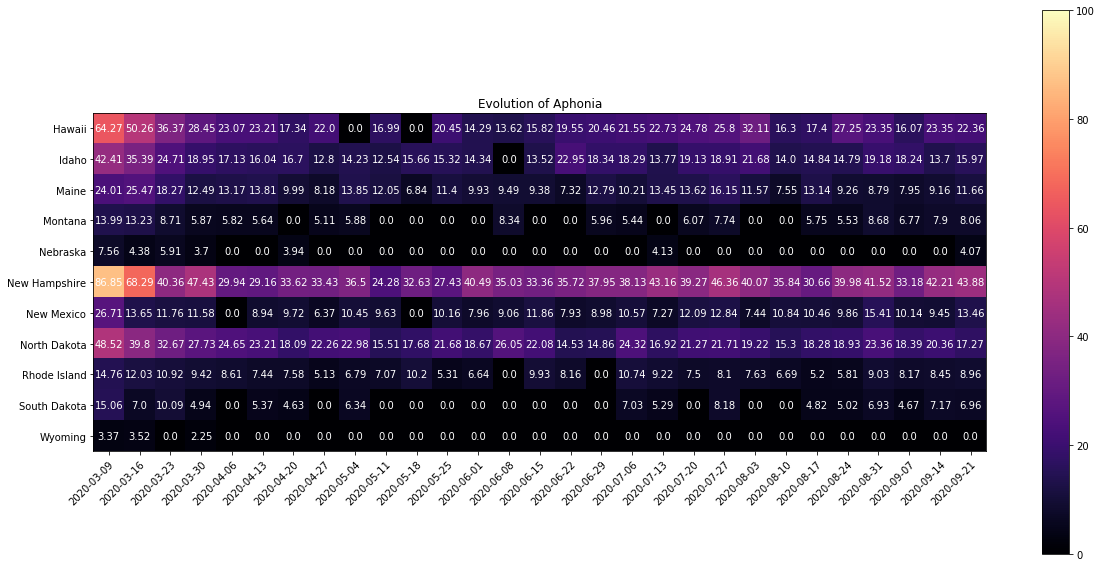

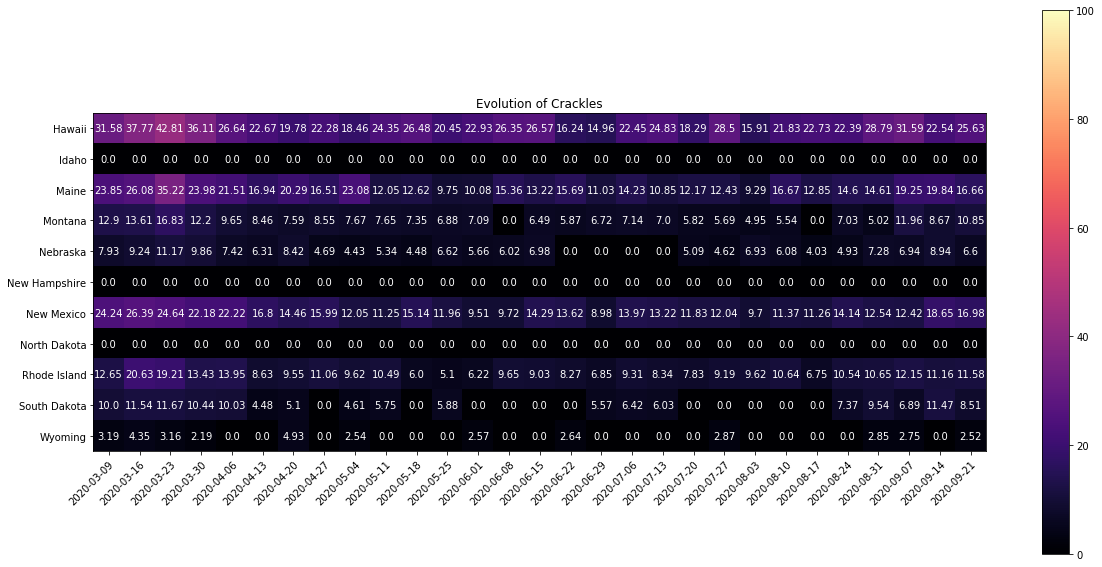

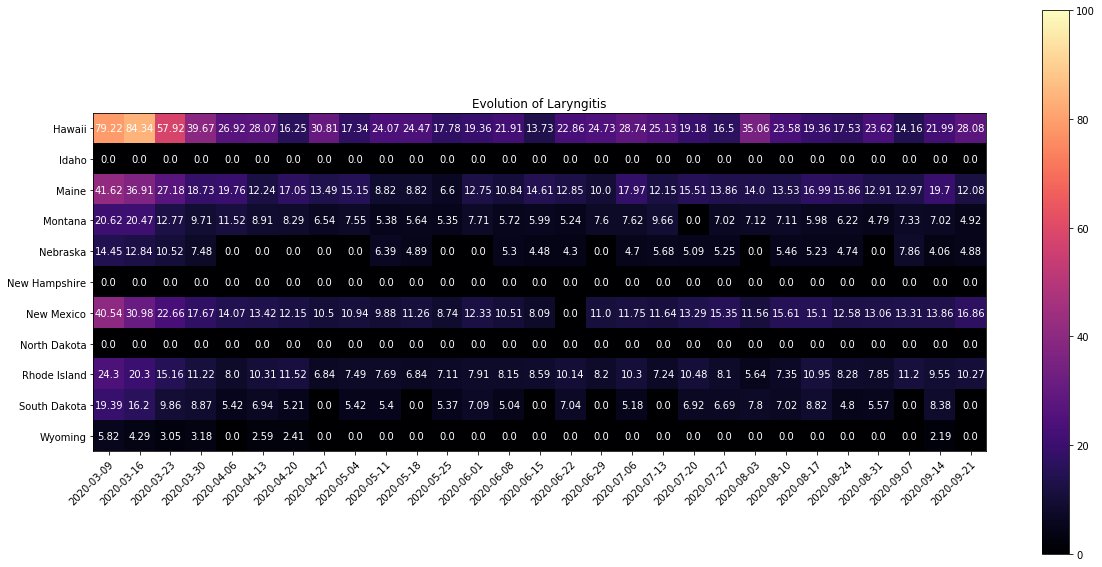

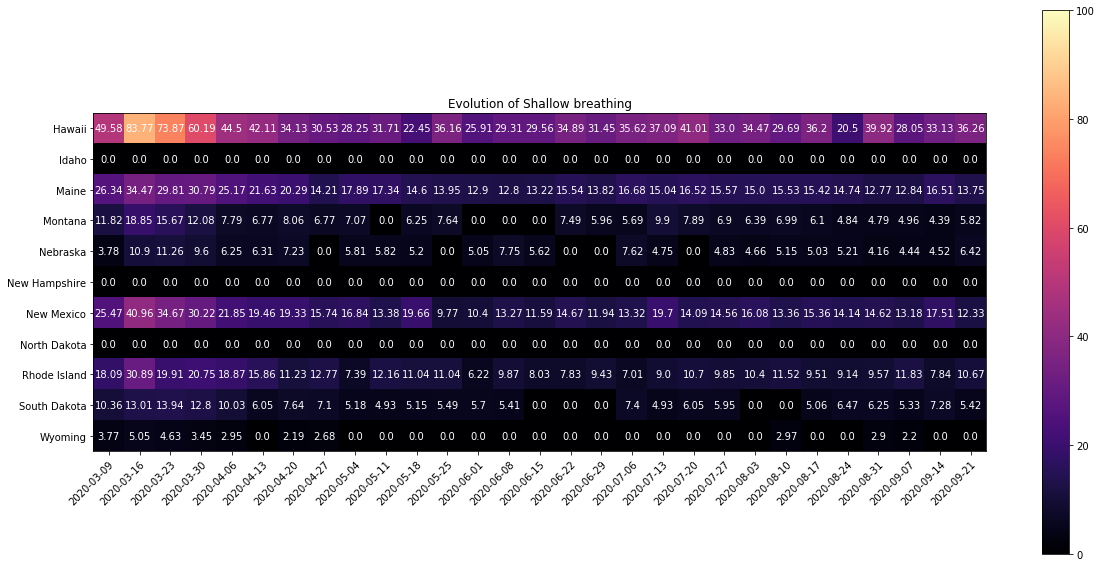

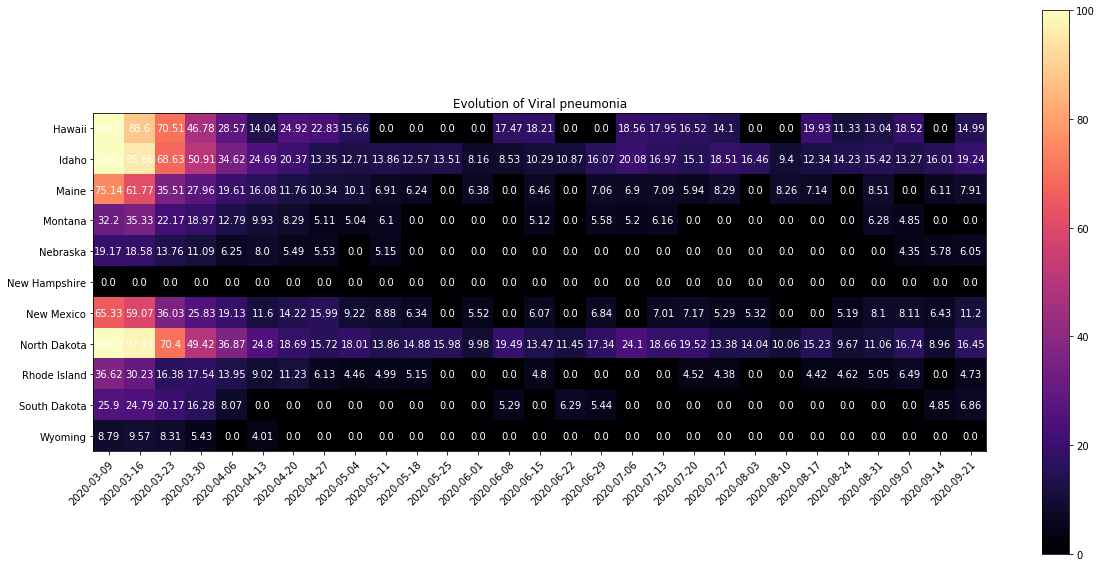

In [18]:
# Plot heatmap
for i in range(mostPop):
    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(sdArr[:,:,i], cmap='magma', vmin=0, vmax=100)
    plt.colorbar(im)

    ax.set_xticks(np.arange(nTime))
    ax.set_yticks(np.arange(nRegions))

    ax.set_xticklabels(uniqueTime)
    ax.set_yticklabels(uniqueRegions)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    for j in range(nTime):
        for k in range(nRegions):
            text = ax.text(j, k, sdArr[k, j, i], ha="center", va="center", color="w")

    ax.set_title('Evolution of ' + namePopSymptoms[i])
    
    plt.show()

## Using PCA to reduce data dimensionality

In [19]:
# Imports
from sklearn.decomposition import PCA

In [20]:
# Perform PCA on the features
pca = PCA()
pca.fit(features)
pcaEVR = pca.explained_variance_ratio_
totalPC = len(pcaEVR)
cumulativeVar = 100*np.cumsum(pcaEVR)

In [21]:
threshCVar = 95

nPC = np.where(cumulativeVar > threshCVar)[0][0]
cVar = cumulativeVar[nPC]
nPC += 1

# print(cVar, nPC)

Text(0.5, 1.0, 'Cumulative Variance Explained vs Number of Principal Components')

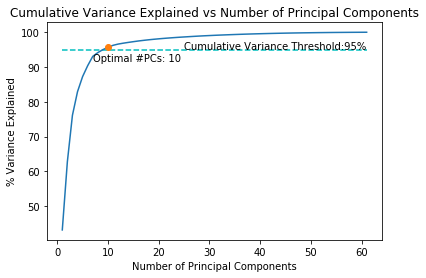

In [22]:
# Plot the cumulative variance vs # of principal components to choose #PCs
fig = plt.figure()
plt.plot(np.linspace(1, totalPC, totalPC), threshCVar*np.ones((totalPC,)), 'c--')
plt.plot(np.linspace(1, totalPC, totalPC), cumulativeVar)
plt.plot(nPC, cVar, 'o')

plt.text(nPC-3, cVar-4, 'Optimal #PCs: ' + str(nPC))
plt.text(totalPC, threshCVar, 'Cumulative Variance Threshold:' + str(threshCVar) + '%', horizontalalignment='right')

plt.xlabel("Number of Principal Components")
plt.ylabel("% Variance Explained")
plt.title("Cumulative Variance Explained vs Number of Principal Components")

Text(0.5, 1.0, 'Search Trends Dataset Reduced to 10D, Visualizing in 2D')

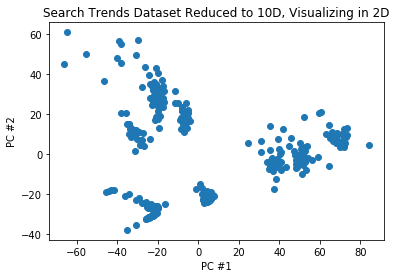

In [23]:
# We have chosen the #PCs -> now reduce the search trends dataset to this dimensionality
pcaRed = PCA(n_components=nPC)
pcaRed.fit(features)
reducedFeat = pcaRed.transform(features)

fig = plt.figure()
plt.scatter(reducedFeat[:,0], reducedFeat[:,1])
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Search Trends Dataset Reduced to " + str(nPC) + "D, Visualizing in 2D")

## Using k-means clustering to evaluate groups in search trends data

In [24]:
# Imports
from sklearn.cluster import KMeans

In [25]:
nClusters = 6    # To be tuned

In [26]:
# Clustering on PCA-reduced data
kmeansRed = KMeans(n_clusters=nClusters, random_state=0)
kmeansRed.fit(reducedFeat)
y_PredRed = kmeansRed.predict(reducedFeat)

In [27]:
# Clustering on original (non-reduced) data
kmeansOri = KMeans(n_clusters=nClusters, random_state=0)
kmeansOri.fit(features)
y_PredOri = kmeansOri.predict(features)

Text(0.5, 1.0, 'Cluster Labels for 61D K-Means (Unreduced Data) with 6 Clusters')

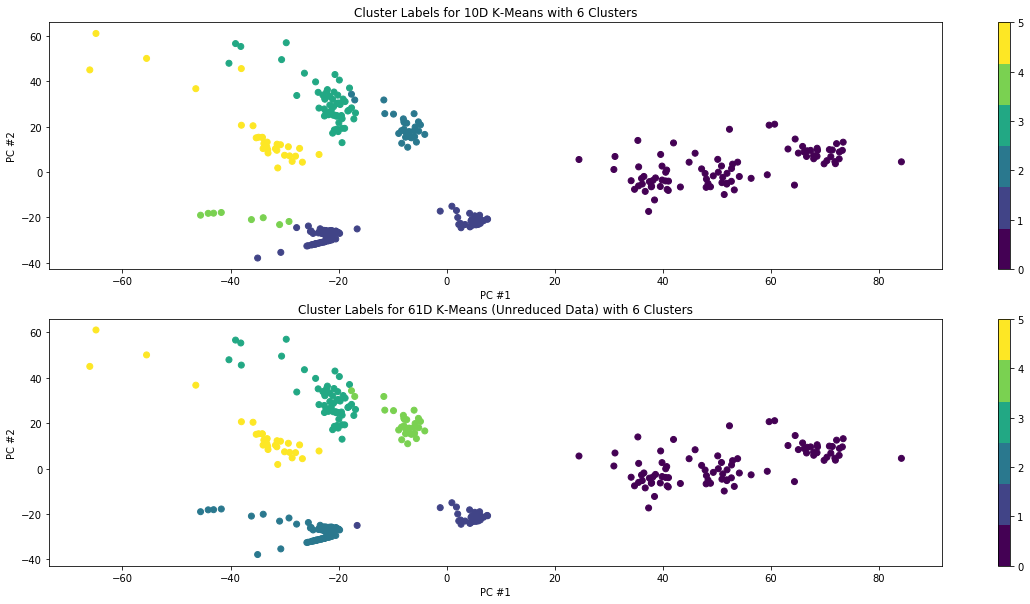

In [28]:
# Plot clustering results for both reduced and non-reduced data

fig = plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.scatter(reducedFeat[:,0], reducedFeat[:,1], c=y_PredRed, cmap=plt.cm.get_cmap('viridis', nClusters))
plt.colorbar(ticks=range(nClusters))
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster Labels for " + str(nPC) + "D K-Means with " + str(nClusters) + " Clusters")

plt.subplot(2,1,2)
plt.scatter(reducedFeat[:,0], reducedFeat[:,1], c=y_PredOri, cmap=plt.cm.get_cmap('viridis', nClusters))
plt.colorbar(ticks=range(nClusters))
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster Labels for " + str(totalPC) + "D K-Means (Unreduced Data) with " + str(nClusters) + " Clusters")

# Task 3: Supervised Learning

In [29]:
#Imports
from sklearn import neighbors
from sklearn import tree
from  sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## Data preprocessing

In [30]:
#replace NaN values to be 0's
myarray[pd.isnull(myarray)] = 0
print(myarray.shape)

#data_r is sorted based on regions
data_r = myarray
#data_t is sorted based on time
data_t = np.array(sorted(myarray,key = lambda x: x[2]))

#split the region-based data to be regions, features, and label
regions_r = data_r[:,0]
features_r = data_r[:,3:-1].astype(float)
label_r = data_r[:,-1].astype(int)
#split the time-based data to be time, features, and label
time_t = data_t[:,2]
features_t = data_t[:,3:-1].astype(float)
label_t = data_t[:,-1].astype(int)

(319, 65)


## Region-based cross-validation (5-fold)

In [31]:
#split the region-based data into 5 folds based on regions
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)
#specify the group indices by regions
groups = regions_r
for i in range(groups.shape[0]):
    if groups[i] == 'Hawaii' or groups[i] ==  'Idaho':
        groups[i] = 1
    elif groups[i] == 'Maine' or groups[i] ==  'Montana':
        groups[i] = 2
    elif groups[i] ==  'North Dakota' or groups[i] ==  'Nebraska':
        groups[i] = 3
    elif groups[i] ==  'New Hampshire' or groups[i] ==  'New Mexico':
        groups[i] = 4
    else:
        groups[i] = 5

### KNN (region-based validation)

<IPython.core.display.Javascript object>


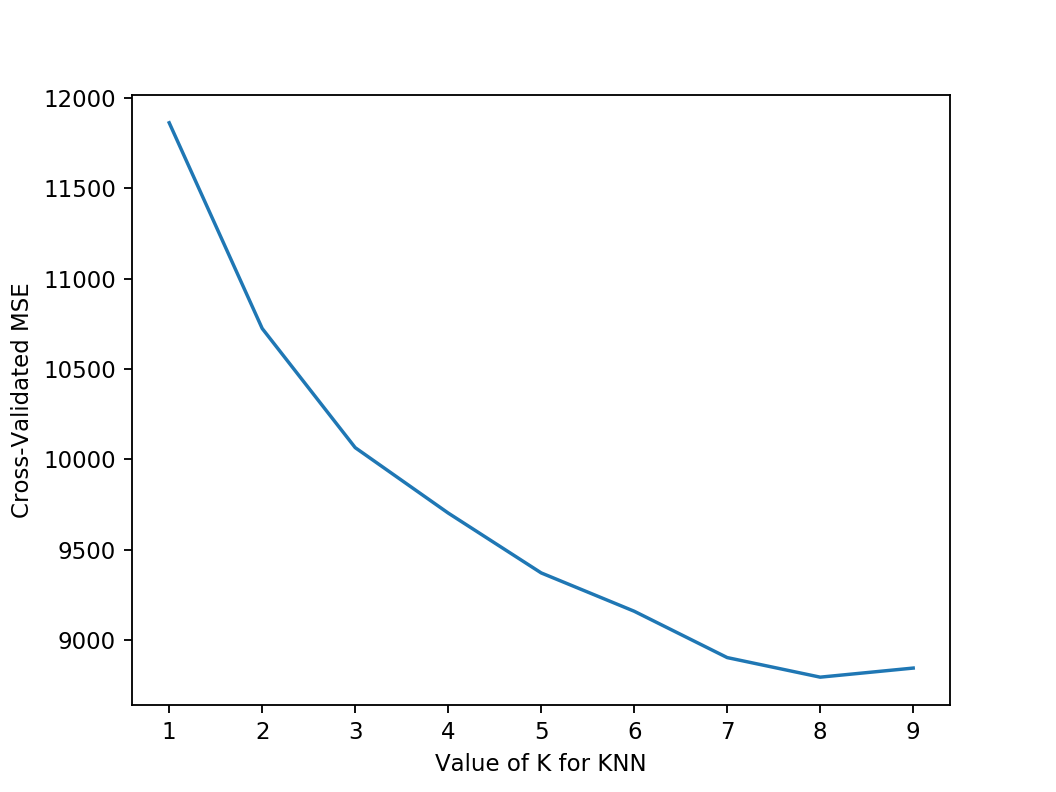

In [42]:
#plot cross-validated MSE error of KNN with respect to different values of k
import matplotlib.pyplot as plt
%matplotlib notebook
k_range_r = range(1, 10)
k_scores_r = []
for k in k_range_r:
    knn_r = neighbors.KNeighborsRegressor(n_neighbors=k)
    loss = abs(cross_val_score(knn_r, features_r,label_r, cv=gkf.split(features_r,label_r, groups), scoring='neg_mean_squared_error'))
    k_scores_r.append(loss.mean())
plt.plot(k_range_r, k_scores_r)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

In [33]:
#k=8 leads to the least MSE, whcih can represent performance of KNN
knn_r_error = k_scores_r[7]
print(knn_r_error)

8794.266271551725


### Decision tree (region-based validation)

In [34]:
#calculate cross-validated MSE of decision tree
dt_r = tree.DecisionTreeRegressor(random_state=1)
loss = abs(cross_val_score(dt_r, features_r, label_r, cv = gkf.split(features_r,label_r, groups), scoring='neg_mean_squared_error'))
dt_r_error = loss.mean()
print(dt_r_error)

10613.914942528736


## Time-based validation

In [35]:
#split the data into train and test sets based on the timepoint '2020-08-10'
#data before '2020-08-10' are in train set and the rest are in test set
#time_t[242] is the first '2020-08-10' which is the splitting point
features_t_train = features_t[0:241]
label_t_train = label_t[0:241]
features_t_test = features_t[241:320]
label_t_test = label_t[241:320]

### KNN (time-based validation)

<IPython.core.display.Javascript object>


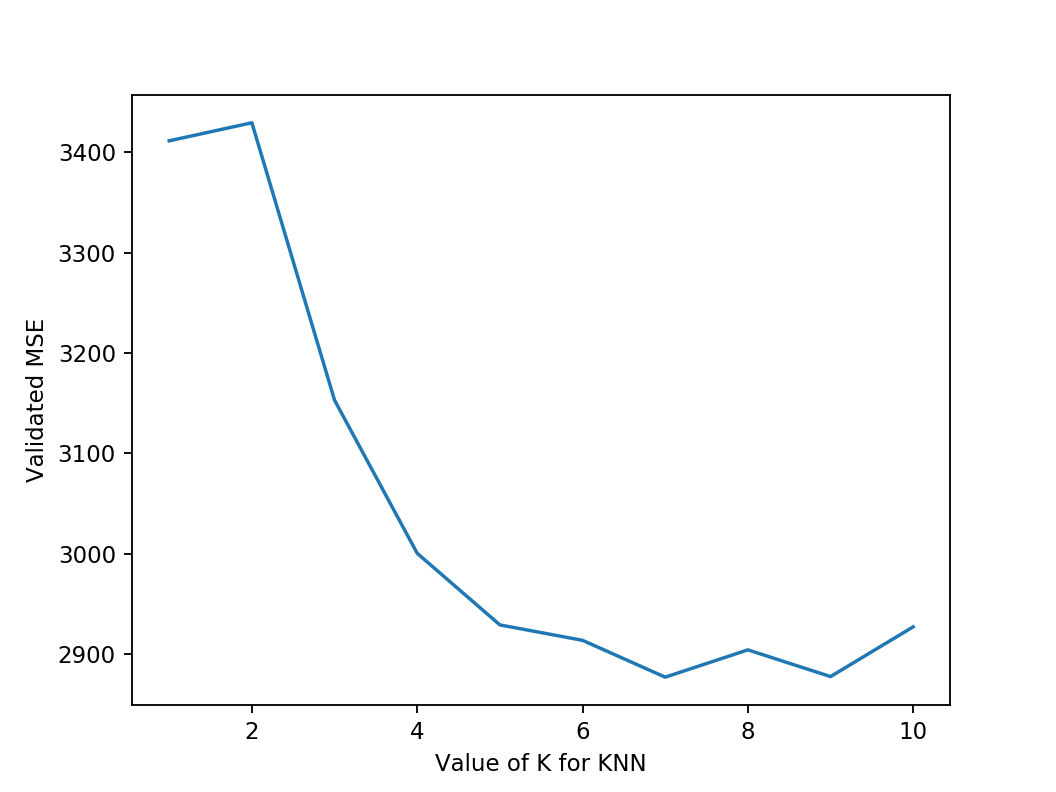

In [43]:
#plot validated MSE error of KNN with respect to different values of k
import matplotlib.pyplot as plt
%matplotlib notebook
k_range_t = range(1, 11)
k_scores_t= []
for k in k_range_t:
    knn_t = neighbors.KNeighborsRegressor(n_neighbors = k)
    knn_t.fit(features_t_train, label_t_train)
    label_t_pred_knn = knn_t.predict(features_t_test)
    loss = mean_squared_error(label_t_test, label_t_pred_knn)
    k_scores_t.append(loss)
plt.plot(k_range_t, k_scores_t)
plt.xlabel('Value of K for KNN')
plt.ylabel('Validated MSE')
plt.show()

In [37]:
#k=7 leads to the least MSE, whcih can represent performance of KNN
knn_t_error = k_scores_t[6]
print(knn_t_error)

2876.8877551020414


### Decision tree (time-based validation)

In [38]:
#calculate validated MSE of decision tree
dt_t = tree.DecisionTreeRegressor(random_state=1)
dt_t.fit(features_t_train, label_t_train)
label_t_pred_dt = dt_t.predict(features_t_test)
dt_t_error = mean_squared_error(label_t_test, label_t_pred_dt)
print(dt_t_error)

5343.089743589743


## Optional part: learn seperate model for each region with time-based validation

### KNN (regional models with time-based validation)

<IPython.core.display.Javascript object>


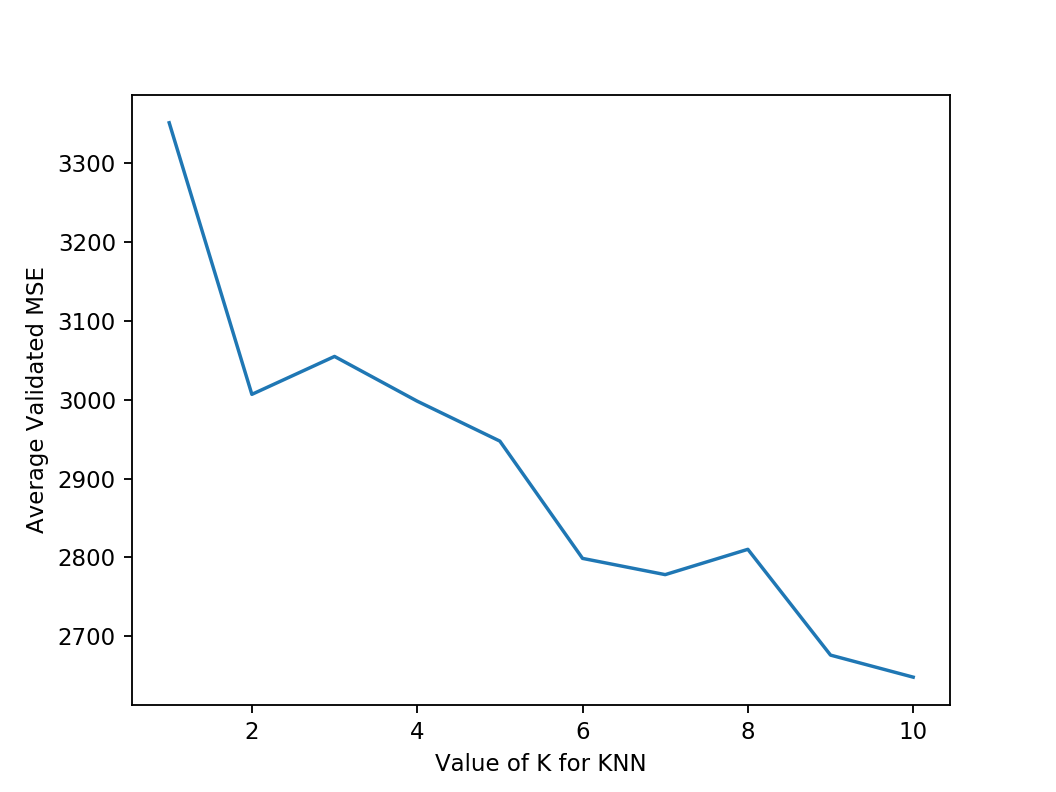

In [44]:
#plot average validated KNN MSE error of all regions with respect to different values of k
import matplotlib.pyplot as plt
%matplotlib notebook
k_range_regional = range(1, 11)
k_scores_regional= []

for k in k_range_regional:
    regional_MSE_knn = []
    for i in range(0,groups.shape[0],29):
        #each iteration deal with data from one city
        regional_features = features_r[i:i+29]
        regional_label = label_r[i:i+29]
        #split the data into train and test sets based on the timepoint 2020-08-10
        #data before 2020-08-10 are in train set and the rest are in test set
        #for data of each region, the 24th. datum is of '2020-08-10' which is the splitting point
        regional_features_train = regional_features[0:23]
        regional_label_train = regional_label[0:23]
        regional_features_test = regional_features[23:29]
        regional_label_test = regional_label[23:29]
        #calculate the KNN MSE of the city of this iteration
        knn = neighbors.KNeighborsRegressor(n_neighbors = k)
        knn.fit(regional_features_train, regional_label_train)
        regional_label_pred_knn = knn.predict(regional_features_test)
        loss_knn = mean_squared_error(regional_label_test, regional_label_pred_knn)
        regional_MSE_knn.append(loss_knn)
    #append the average validated MSE of the current k
    regional_MSE_knn = np.array(regional_MSE_knn)
    k_scores_regional.append(regional_MSE_knn.mean())

plt.plot(k_range_regional, k_scores_regional)
plt.xlabel('Value of K for KNN')
plt.ylabel('Average Validated MSE')
plt.show()

In [40]:
#k=10 leads to the least average MSE, whcih can represent performance of KNN
knn_regional_error = k_scores_regional[9]
print(knn_regional_error)

2648.1472727272726


### Decision tree (regional models with time-based validation)

In [41]:
#calculate the average validated decision tree MSE error of all regions
regional_MSE_dt = []
for i in range(0,groups.shape[0],29):
    #each iteration deal with data from one city
    regional_features = features_r[i:i+29]
    regional_label = label_r[i:i+29]
    #split the data into train and test sets based on the timepoint 2020-08-10
    #data before 2020-08-10 are in train set and the rest are in test set
    #for data of each region, the 24th. datum is of '2020-08-10' which is the splitting point
    regional_features_train = regional_features[0:23]
    regional_label_train = regional_label[0:23]
    regional_features_test = regional_features[23:29]
    regional_label_test = regional_label[23:29]
    #calculate the decision tree MSE of the city of this iteration
    dt = tree.DecisionTreeRegressor(random_state=1)
    dt.fit(regional_features_train, regional_label_train)
    regional_label_pred_dt = dt.predict(regional_features_test)
    loss_dt = mean_squared_error(regional_label_test, regional_label_pred_dt)
    regional_MSE_dt.append(loss_dt)
    
regional_MSE_dt = np.array(regional_MSE_dt)
dt_regional_error = regional_MSE_dt.mean()
print(dt_regional_error)

3384.484848484848
